<a href="https://colab.research.google.com/github/TempestFlow/TripPlannerAI/blob/main/notebooks/trip_planner_gemini_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Išmanus kelionių maršrutų planuotojas – Gemini API prototipas

Šis notebook'as demonstruoja DI sistemos **„Išmanus kelionių maršrutų planuotojas“** prototipą,
sukurtą naudojant **Google Gemini API**.

**Tikslas** – parodyti visą DI agento veikimo procesą:

1. Įvesties duomenų (kelionės užklausos) priėmimas.
2. Duomenų paruošimas ir prompt'o suformavimas.
3. Užklausos siuntimas į *Gemini* modelį per `google-genai` SDK.
4. Sugeneruoto atsakymo (maršruto plano) gavimas ir apdorojimas.
5. Rezultatų vizualizacija (dienų ir veiklų lentelė, grafikas).

Modelis naudojamas kaip **generatyvus planavimo variklis**: pagal vartotojo pageidavimus
sugeneruoja kelių dienų kelionės maršrutą, lankytinas vietas, viešbučius, restoranus ir bendrus patarimus.


## Sistemos apžvalga

**Projekto idėja**

„Išmanus kelionių maršrutų planuotojas“ leidžia vartotojui įvesti kelionės parametrus
(paskirties vietą, datas, biudžeto lygį, pomėgius), o DI agentas su Gemini modeliu:

- sugeneruoja kelių dienų kelionės maršrutą,
- parenka lankytinas vietas su trumpais aprašymais,
- pasiūlo viešbučius ir restoranus,
- pateikia bendrus kelionės patarimus (biudžetas, transportas ir pan.).

**Šiame notebook'e demonstruojamas pilnas DI agento veikimo procesas:**

1. Vartotojo įvesties struktūra (`TripInput` objektas – X).
2. Prompt'o generavimas pagal įvestus kelionės parametrus.
3. Užklausos siuntimas į Gemini modelį per `google-genai` Python SDK.
4. Sugeneruoto kelionės plano JSON gavimas ir parsinimas į Python struktūras.
5. Rezultatų vizualizacija: dienų ir veiklų lentelė bei grafikas, rodantis veiklų skaičių kiekvieną kelionės dieną.

Tokį prototipą galima integruoti į platesnę sistemą (web ar mobilų sprendimą),
kur back-end dalis kviečia Gemini API, saugo sugeneruotus planus duomenų bazėje
ir leidžia vartotojui juos redaguoti bei eksportuoti.


In [18]:
# 2 langelis – diegiame reikalingas bibliotekas.
# Šis langelis reikalingas tik pirmą kartą arba po runtime restart.
!pip install -q -U google-genai pandas matplotlib


In [19]:
# 3 langelis – importuojame bibliotekas ir sukuriame Gemini API klientą.
# Čia sukonfigūruojamas ryšys su Google Gemini paslauga.

from google import genai
import os
import json
from dataclasses import dataclass
from typing import List, Dict, Any

# Bandome paskaityti iš Colab slaptų kintamųjų
API_KEY = None
try:
    from google.colab import userdata
    API_KEY = userdata.get("GEMINI_API_KEY")
except Exception:
    pass

# Jei nėra – bandome iš aplinkos kintamojo
if not API_KEY:
    API_KEY = os.getenv("GEMINI_API_KEY")

# Jei vis tiek nėra – keliame aiškią klaidą
if not API_KEY:
    raise ValueError("Nerastas GEMINI_API_KEY. Nustatyk jį Colab userdata arba ENV kintamajame.")

client = genai.Client(api_key=API_KEY)


In [20]:
# 4 langelis – apibrėžiame duomenų struktūras (klases).
# TripInput – kaip atrodys vartotojo įvestis (X).
# TripPlanDay – palengvina dienos suvestinės saugojimą ir atvaizdavimą.

@dataclass
class TripInput:
    destination: str
    start_date: str
    end_date: str
    budget_level: str
    travelers_count: int
    interests: List[str]
    transport_preference: str
    language: str = "lt"


@dataclass
class TripPlanDay:
    day_number: int
    date: str
    title: str
    activities_count: int


In [21]:
# 5 langelis – funkcija prompt'ui sugeneruoti ir DI agento funkcija.
# build_trip_prompt – paverčia TripInput į aiškų tekstinį užklausą modeliui.
# generate_trip_plan – kviečia Gemini, gauna JSON ir jį parsinina.

def build_trip_prompt(trip: TripInput) -> str:
    """
    Sugeneruoja aiškų prompt'ą Gemini modeliui.
    """
    return f"""
Tu esi „Išmanus kelionių maršrutų planuotojas“.

PASKIRTIES VIETA: {trip.destination}.
Tai reiškia, kad kelionės maršrutas turi būti sudaromas būtent šioje šalyje / mieste.
Nepainiok su kitomis šalimis.

Sugeneruok kelių dienų kelionės maršrutą pagal šiuos parametrus:

- Paskirties vieta: {trip.destination}
- Kelionės pradžia: {trip.start_date}
- Kelionės pabaiga: {trip.end_date}
- Biudžeto lygis: {trip.budget_level}
- Keliautojų skaičius: {trip.travelers_count}
- Pagrindiniai pomėgiai: {", ".join(trip.interests)}
- Transporto preferencijos: {trip.transport_preference}
- Atsakymo kalba: {trip.language}

GRĄŽINK atsakymą GRIEŽTAI JSON formatu su ANGLIŠKAIS laukų pavadinimais:

{{
  "summary": "...",
  "days": [
    {{
      "day_number": 1,
      "date": "YYYY-MM-DD",
      "title": "...",
      "items": [
        {{
          "type": "POI_VISIT | HOTEL | RESTAURANT | TRANSPORT | OTHER",
          "time": "HH:MM-HH:MM",
          "name": "...",
          "short_description": "..."
        }}
      ]
    }}
  ],
  "accommodation": [
    {{
      "name": "...",
      "price_per_night": 0,
      "currency": "EUR",
      "short_description": "..."
    }}
  ],
  "restaurants": [
    {{
      "name": "...",
      "type": "...",
      "price_level": "€ | €€ | €€€"
    }}
  ],
  "tips": ["...", "..."]
}}

Tekstas gali būti lietuvių kalba, bet JSON raktų pavadinimai turi būti ANGLIŠKI (summary, days, accommodation, restaurants, tips).
Be komentarų ir papildomo teksto už JSON ribų.
"""


def generate_trip_plan(trip: TripInput, model_name: str = "gemini-2.5-flash") -> Dict[str, Any]:
    """
    Aukšto lygio DI agento funkcija:
    1) sukuria prompt'ą,
    2) kviečia Gemini,
    3) parsinina JSON,
    4) grąžina kelionės planą kaip dict.
    """
    prompt = build_trip_prompt(trip)
    print("=== PROMPT (pirmos ~300 simbolių) ===\n")
    print(prompt[:300], "...\n")

    response = client.models.generate_content(
        model=model_name,
        contents=prompt
    )

    raw_text = response.text
    cleaned = raw_text.strip()

    # jei grąžino ```json ... ``` bloką – nuimame "fences"
    if cleaned.startswith("```"):
        cleaned = cleaned.strip("`")
        cleaned = cleaned.replace("json\n", "", 1).strip()

    try:
        plan = json.loads(cleaned)
    except json.JSONDecodeError as e:
        print("JSON klaida:", e)
        print("Pilnas atsakymas:\n", cleaned)
        raise

    return plan


In [22]:
# 6 langelis – suformuojame pavyzdinę įvestį (X).
# Čia vartotojo „forma“ paverčiama į TripInput objektą.
# Pakeitę destination / datas / biudžetą lengvai sukursite naują scenarijų.

input_data = {
    "destination": "Vilnius, Lietuva",
    "start_date": "2025-07-01",
    "end_date": "2025-07-05",
    "budget_level": "aukštas",
    "travelers_count": 4,
    "interests": ["muziejai", "pramogų parkai", "architektūra"],
    "transport_preference": "metro + taksi",
    "language": "lt"
}

trip_input = TripInput(**input_data)
trip_input


TripInput(destination='Vilnius, Lietuva', start_date='2025-07-01', end_date='2025-07-05', budget_level='aukštas', travelers_count=4, interests=['muziejai', 'pramogų parkai', 'architektūra'], transport_preference='metro + taksi', language='lt')

In [23]:
# 7 langelis – kviečiame DI agentą ir gauname kelionės planą (y).
# Čia įvyksta visas „magiškas“ DI darbas.

trip_plan = generate_trip_plan(trip_input)

print("\n=== RAKTAI PLANE ===")
print(trip_plan.keys())

# summary – pagal nutylėjimą angliškas raktas
summary = trip_plan.get("summary") or trip_plan.get("kelionesPavadinimas", "")
print("\n=== SANTRAUKA ===\n")
print(summary)

# days – jei modelis vis tiek sugalvos lietuvišką 'dienos'
days = trip_plan.get("days") or trip_plan.get("dienos", [])

print("\n=== PIRMĀ DIENA (jei yra) ===\n")
if days:
    print(json.dumps(days[0], indent=2, ensure_ascii=False))
else:
    print("Dienų nerasta JSON'e.")


=== PROMPT (pirmos ~300 simbolių) ===


Tu esi „Išmanus kelionių maršrutų planuotojas“.

PASKIRTIES VIETA: Vilnius, Lietuva.
Tai reiškia, kad kelionės maršrutas turi būti sudaromas būtent šioje šalyje / mieste.
Nepainiok su kitomis šalimis.

Sugeneruok kelių dienų kelionės maršrutą pagal šiuos parametrus:

- Paskirties vieta: Vilnius, Li ...


=== RAKTAI PLANE ===
dict_keys(['summary', 'days', 'accommodation', 'restaurants', 'tips'])

=== SANTRAUKA ===

Šis penkių dienų maršrutas po Vilnių sukurtas keturių keliautojų grupei, ieškančiai prabangios patirties, derinant istorinius muziejus, įspūdingą architektūrą ir unikalias pramogas. Maršrute numatytas patogus transportas taksi ir dėmesys aukščiausios klasės maitinimo įstaigoms bei apgyvendinimui, siekiant maksimaliai padidinti komfortą ir įspūdžius. Nors Vilniuje nėra metro, taksi ir vietinis viešasis transportas užtikrins patogų judėjimą mieste. Jūsų laukia kelionė per barokinio senamiesčio grožį, moderniosios Lietuvos istorijos įžvalg

In [24]:
# 8 langelis – transformuojame „days“ į patogią lentelę ir nubraižome paprastą grafiką.
# Čia parodoma, kiek veiklų suplanuota kiekvieną kelionės dieną.


days = trip_plan.get("days") or trip_plan.get("dienos", [])

day_rows: List[TripPlanDay] = []

for idx, d in enumerate(days, start=1):
    # bandome paimti tiek angliškus, tiek LT raktus
    day_number = d.get("day_number") or d.get("dienosNumeris") or idx
    date = d.get("date") or d.get("data", "")
    title = d.get("title") or d.get("pavadinimas", "")
    items = d.get("items") or d.get("veiklos", [])

    day_rows.append(
        TripPlanDay(
            day_number=day_number,
            date=date,
            title=title,
            activities_count=len(items),
        )
    )

df_days = pd.DataFrame([vars(d) for d in day_rows])
df_days


,day_number,date,title,activities_count
0,1,2025-07-01,Atvykimas ir Senamiesčio didybė,5
1,2,2025-07-02,Istorija ir bohemiškas Užupis,6
2,3,2025-07-03,Modernusis menas ir istorijos pamokos,5
3,4,2025-07-04,Panoraminiai vaizdai ir išskirtinės pramogos,6
4,5,2025-07-05,Atsisveikinimas su Vilniumi ir išvykimas,6


In [25]:
# 9 langelis – išskleidžiame visas veiklas (items) į vieną lentelę ir
# nubraižome „stacked bar“ grafiką: kiek kokio tipo veiklų yra kiekvieną dieną.

days = trip_plan.get("days") or trip_plan.get("dienos", [])

rows = []
for d in days:
    day_number = d.get("day_number") or d.get("dienosNumeris")
    date = d.get("date") or d.get("data", "")
    title = d.get("title") or d.get("pavadinimas", "")
    items = d.get("items") or d.get("veiklos", [])

    for item in items:
        rows.append({
            "day_number": day_number,
            "date": date,
            "day_title": title,
            "type": item.get("type"),
            "time": item.get("time"),
            "name": item.get("name"),
            "description": item.get("short_description", "")
        })

df_items = pd.DataFrame(rows)
df_items.head(20)


,day_number,date,day_title,type,time,name,description
0,1,2025-07-01,Atvykimas ir Senamiesčio didybė,HOTEL,14:00-15:00,Įsiregistravimas į Grand Hotel Kempinski Vilnius,Aukščiausios klasės viešbutis Vilniaus širdyje...
1,1,2025-07-01,Atvykimas ir Senamiesčio didybė,RESTAURANT,15:30-17:00,Pietūs restorane 'Telegrafas',"Elegantiškas restoranas, įsikūręs Grand Hotel ..."
2,1,2025-07-01,Atvykimas ir Senamiesčio didybė,POI_VISIT,17:00-18:30,Vilniaus Katedra ir Katedros varpinė,Apsilankykite svarbiausioje Lietuvos katalikų ...
3,1,2025-07-01,Atvykimas ir Senamiesčio didybė,ARCHITECTURE,18:30-19:30,Pasivaikščiojimas Katedros aikšte ir Gedimino ...,Mėgaukitės gyva atmosfera ir grožėkitės archit...
4,1,2025-07-01,Atvykimas ir Senamiesčio didybė,RESTAURANT,20:00-22:00,Vakarienė restorane 'Pacai Restaurant',"Aukščiausios klasės restoranas, įsikūręs istor..."
5,2,2025-07-02,Istorija ir bohemiškas Užupis,POI_VISIT,09:30-12:00,Lietuvos Didžiosios Kunigaikštystės Valdovų rūmai,Pažinkite Lietuvos valdovų istoriją ir kultūrą...
6,2,2025-07-02,Istorija ir bohemiškas Užupis,POI_VISIT,12:00-13:30,Gedimino kalnas ir bokštas,"Užkopkite į Gedimino kalną, aplankykite Vilnia..."
7,2,2025-07-02,Istorija ir bohemiškas Užupis,RESTAURANT,13:30-15:00,Pietūs restorane 'Džiaugsmas',"Šiuolaikinės lietuviškos virtuvės restoranas, ..."
8,2,2025-07-02,Istorija ir bohemiškas Užupis,ARCHITECTURE,15:00-17:00,Šv. Onos ir Bernardinų bažnyčių ansamblis,Pasigrožėkite nuostabiu gotikinės architektūro...
9,2,2025-07-02,Istorija ir bohemiškas Užupis,OTHER,17:00-19:00,Pasivaikščiojimas po Užupio Respubliką,Atraskite unikalų menininkų rajoną su sava kon...


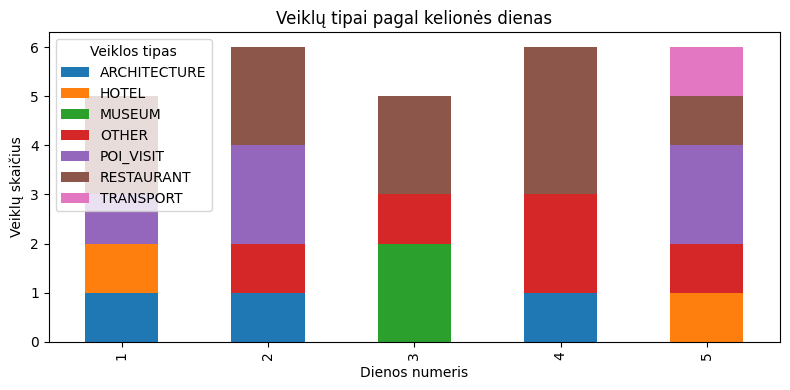

In [26]:
# Grafikas: kiek kokio tipo veiklų yra kiekvieną dieną

if not df_items.empty:
    type_counts = (
        df_items
        .pivot_table(
            index="day_number",
            columns="type",
            values="name",
            aggfunc="count",
            fill_value=0
        )
        .sort_index()
    )

    ax = type_counts.plot(
        kind="bar",
        figsize=(8, 4),
        stacked=True
    )

    ax.set_xlabel("Dienos numeris")
    ax.set_ylabel("Veiklų skaičius")
    ax.set_title("Veiklų tipai pagal kelionės dienas")
    plt.legend(title="Veiklos tipas")
    plt.tight_layout()
    plt.show()
else:
    print("Nėra duomenų veiklų grafikui – df_items tuščias.")


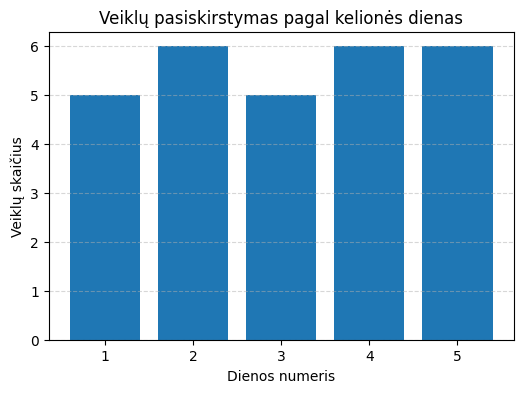

In [27]:
# 8 langelis – grafikas: veiklų skaičius per dieną

if not df_days.empty:
    plt.figure(figsize=(6, 4))
    plt.bar(df_days["day_number"], df_days["activities_count"])
    plt.xlabel("Dienos numeris")
    plt.ylabel("Veiklų skaičius")
    plt.title("Veiklų pasiskirstymas pagal kelionės dienas")
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.show()
else:
    print("Nėra duomenų grafikui – df_days tuščias.")


## Išvados

Šiame notebook'e pademonstruota veikiančios DI sistemos prototipo versija,
naudojanti „Google Gemini“ modelį kelionių maršrutų planavimui.

Pagrindinės išvados:

1. **End-to-End procesas įgyvendintas.**
   Sistemoje aiškiai atskirtos įvesties (`TripInput`), prompt'o generavimo,
   Gemini modelio kvietimo, JSON parsinimo ir rezultatų vizualizavimo dalys.

2. **Gemini modelis tinka kelionių planavimui.**
   Modelis, gavęs aiškią struktūruotą užklausą, sugeba sugeneruoti logišką kelių dienų
   maršrutą, įtraukiant lankytinas vietas, maitinimo vietas ir bendrus patarimus.

3. **Struktūrizuota JSON išvestis leidžia toliau apdoroti duomenis.**
   Sugeneruotą planą galima patogiai versti į `pandas` lenteles, braižyti grafikus
   ir ateityje integruoti su išoriniais kelionių API ar duomenų bazėmis.

4. **Prototipas paruoštas tolimesnei plėtrai.**
   Pridėjus vartotojų autentifikaciją, išorinį vietų/viešbučių API sluoksnį
   ir nuolatinę duomenų saugyklą, šį DI agentą būtų galima naudoti
   kaip brandesnės „Išmanaus kelionių maršrutų planuotojo“ sistemos branduolį.
